In [1]:
!pip install pymaxflow

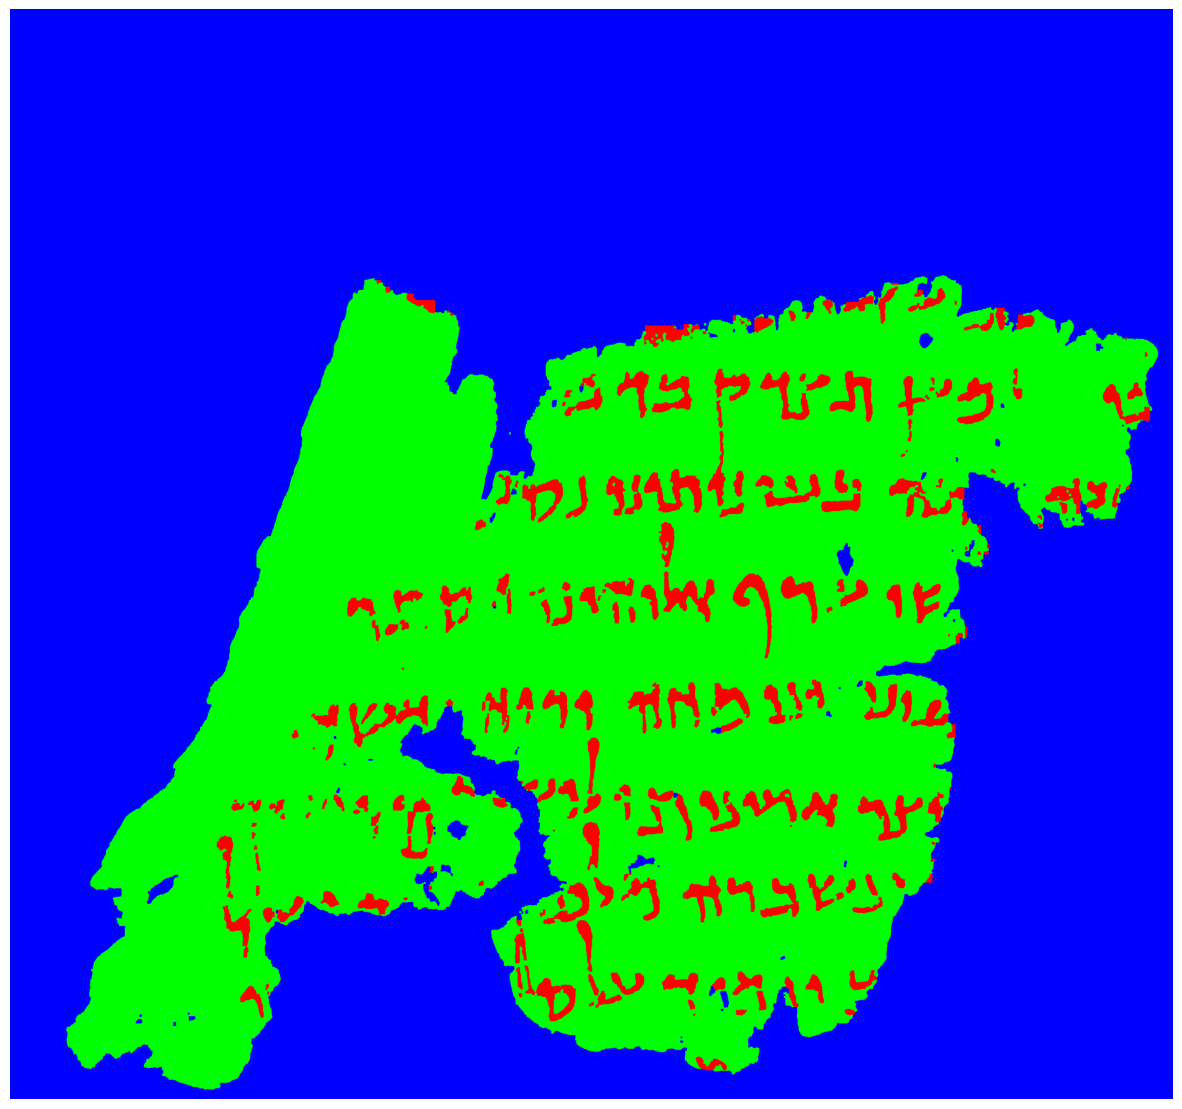

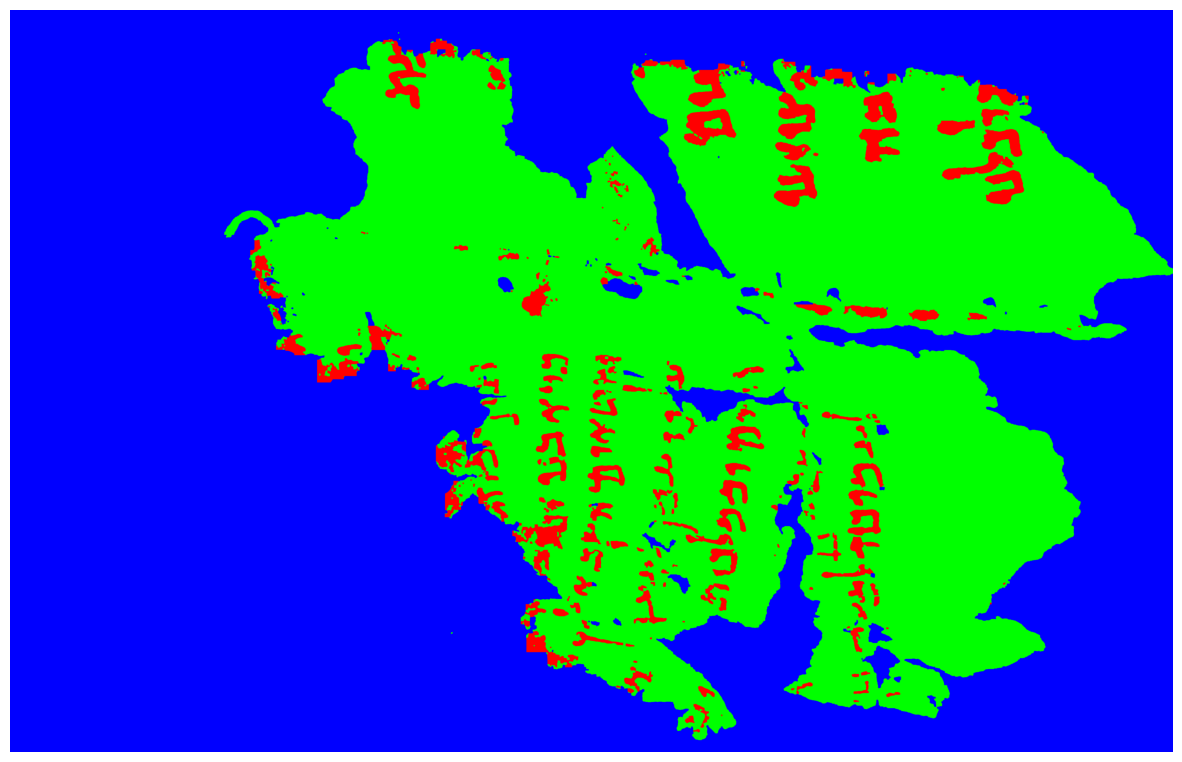

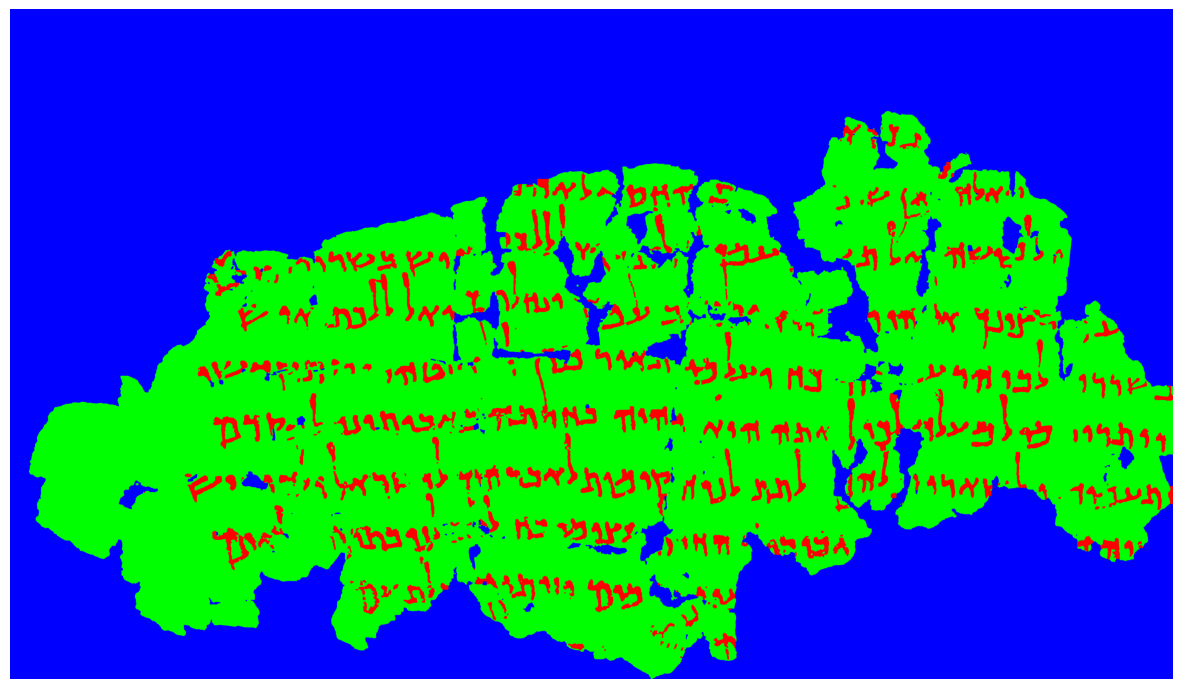

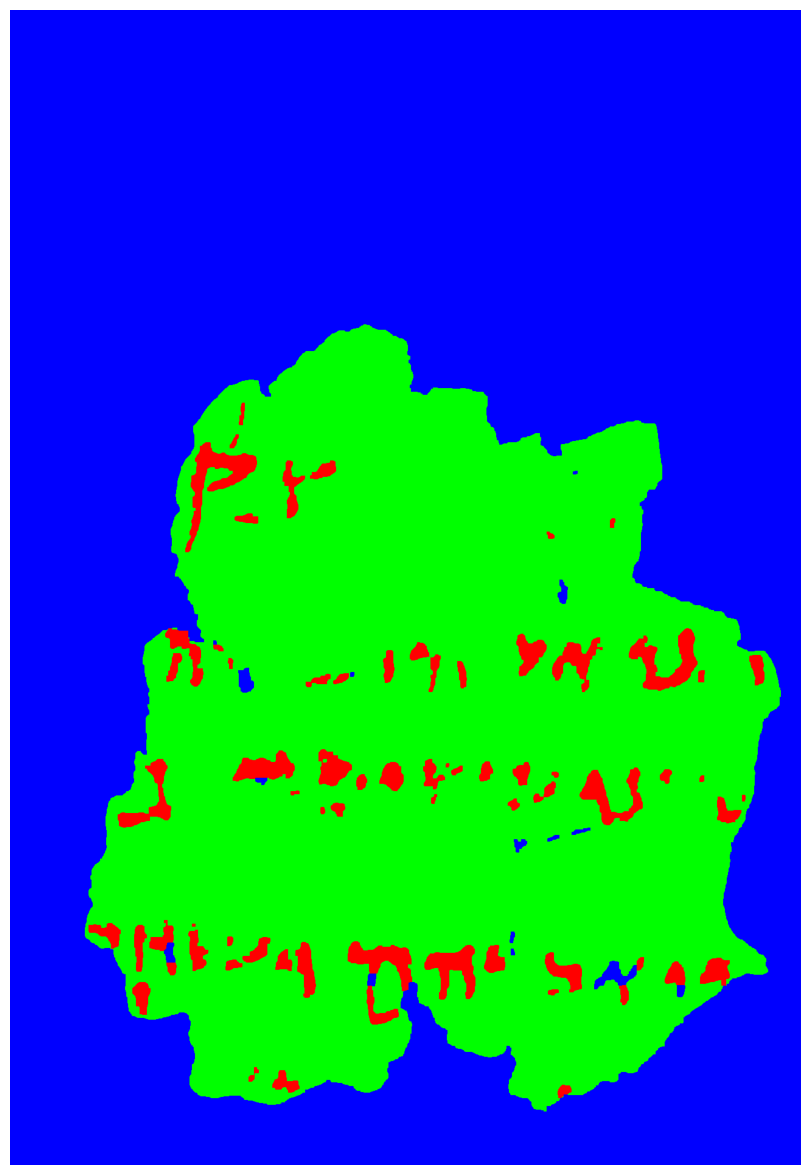

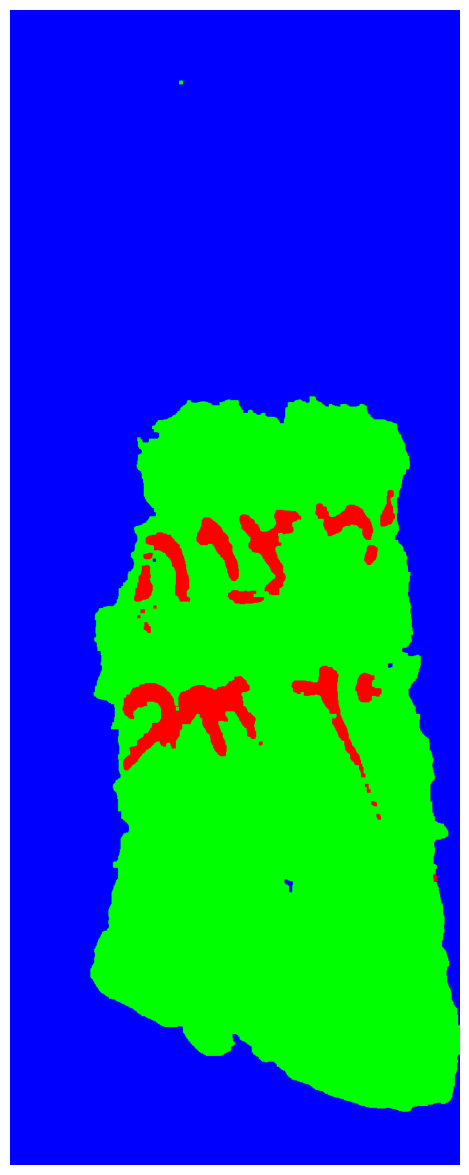

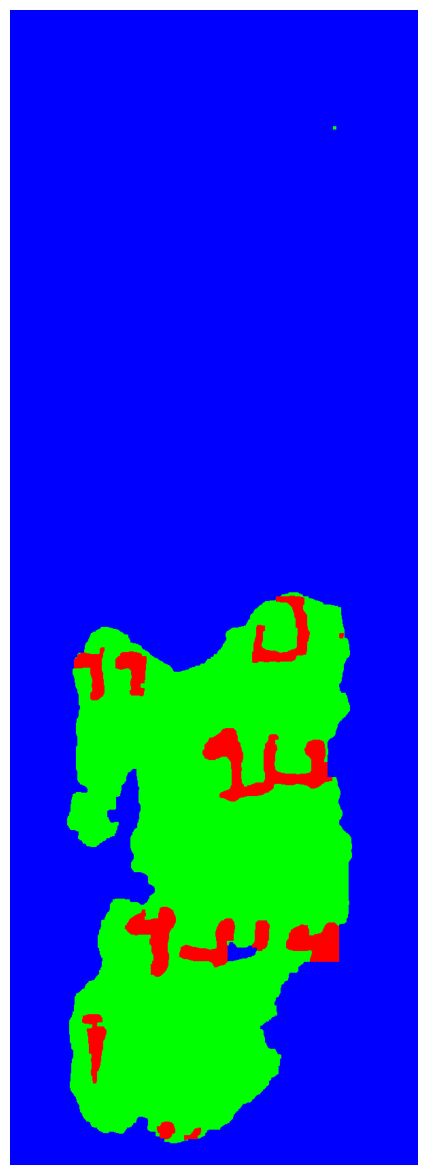

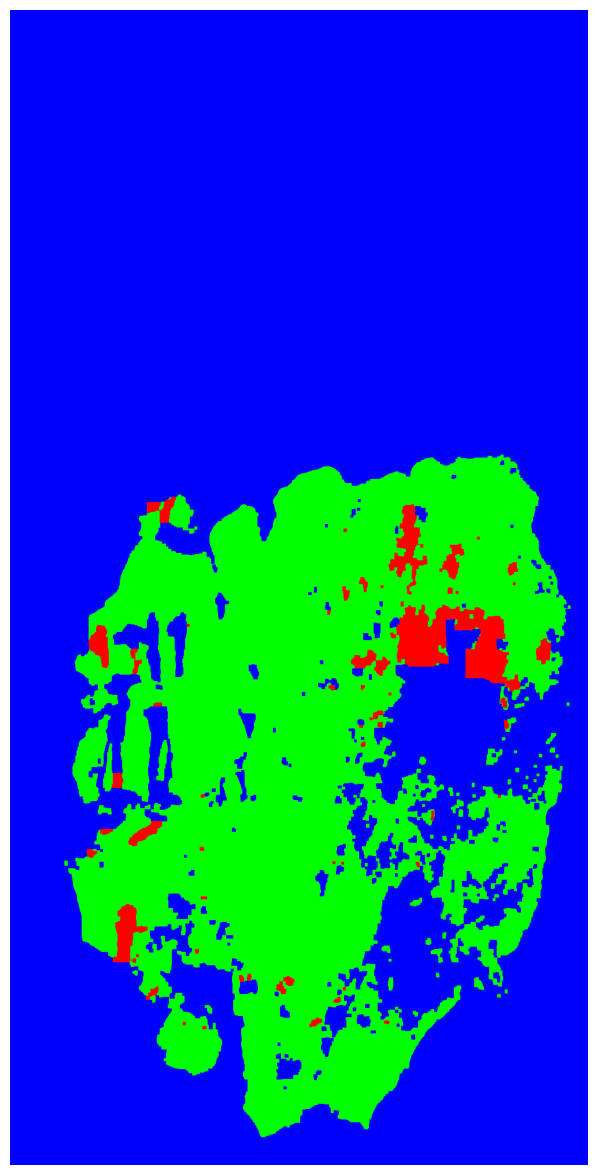

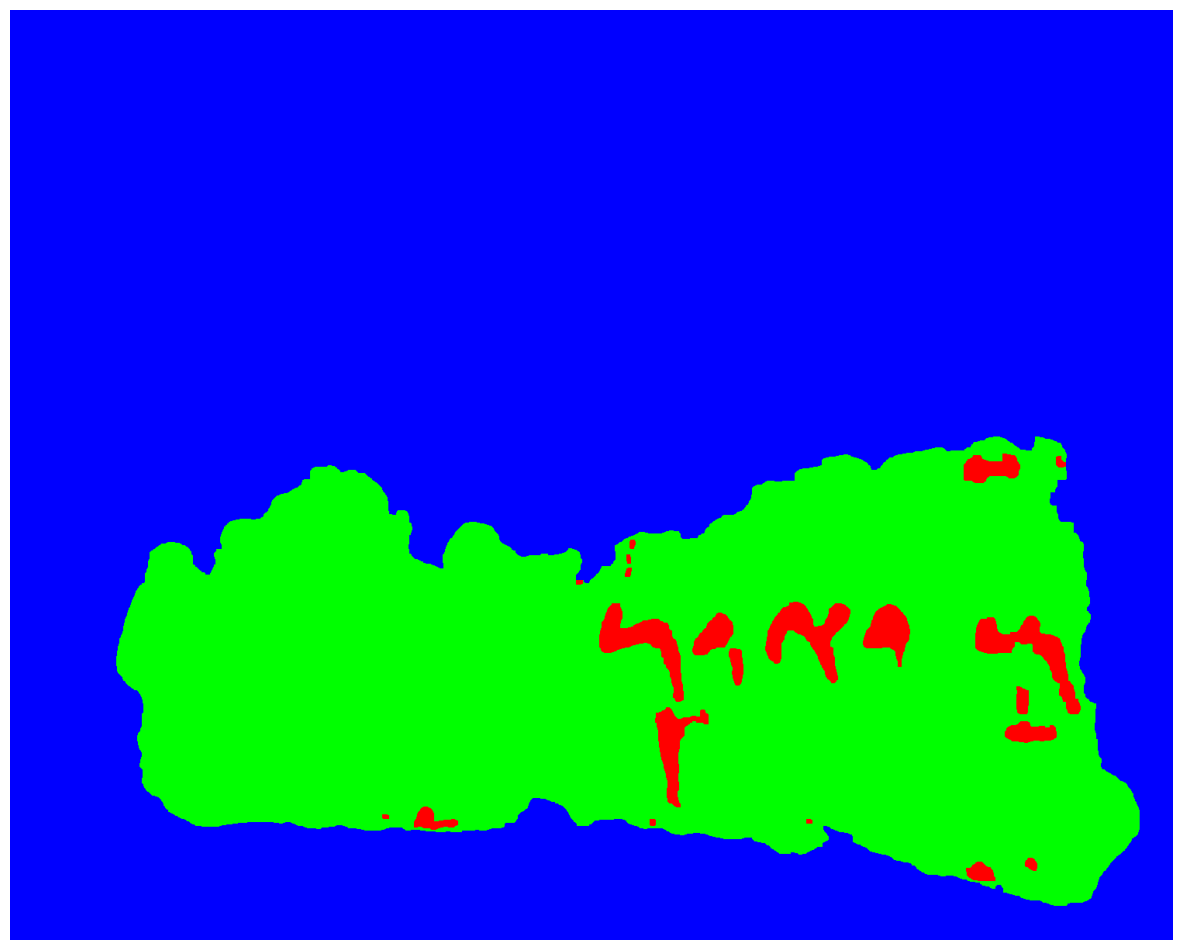

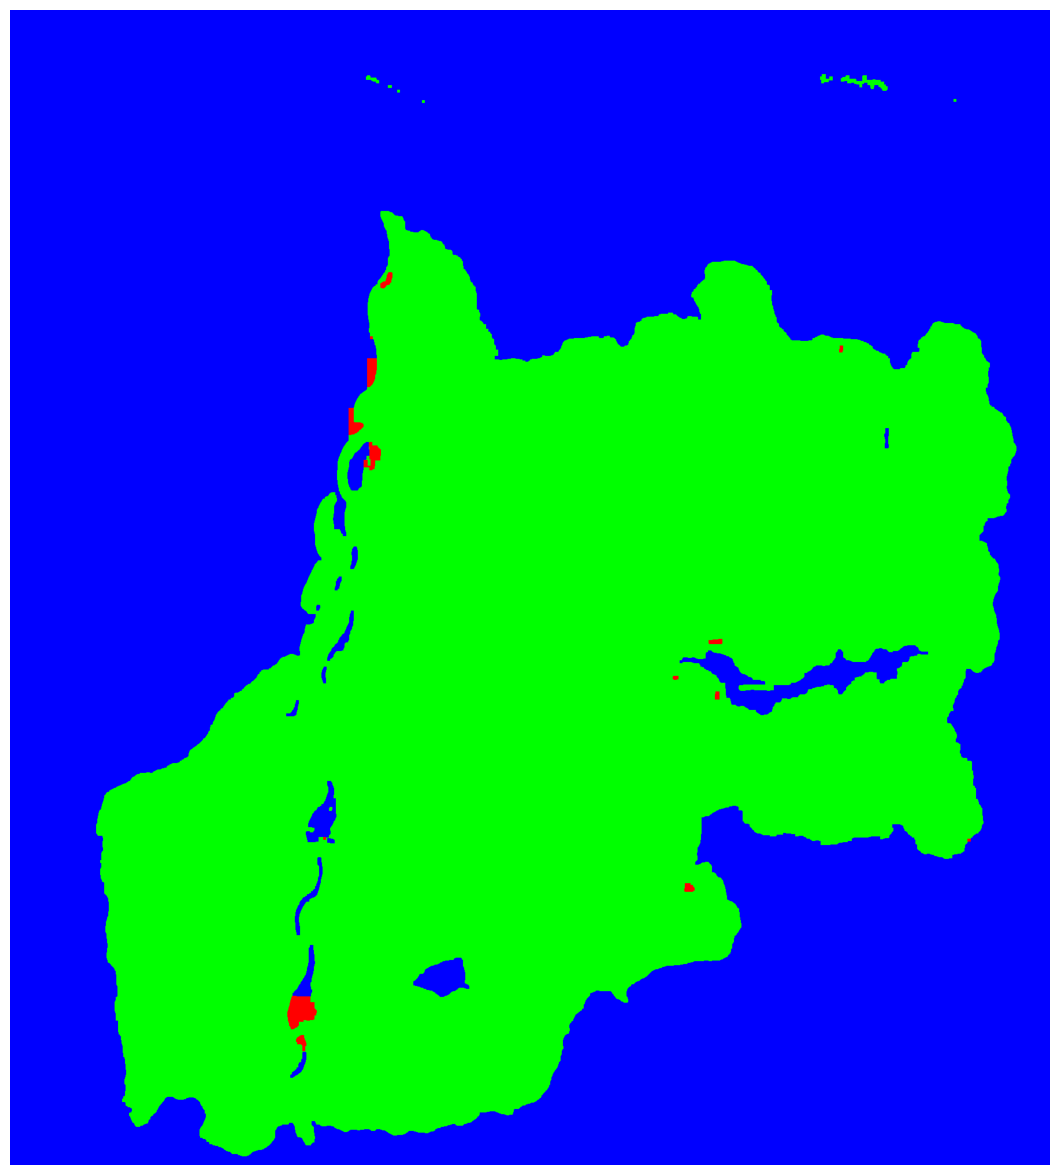

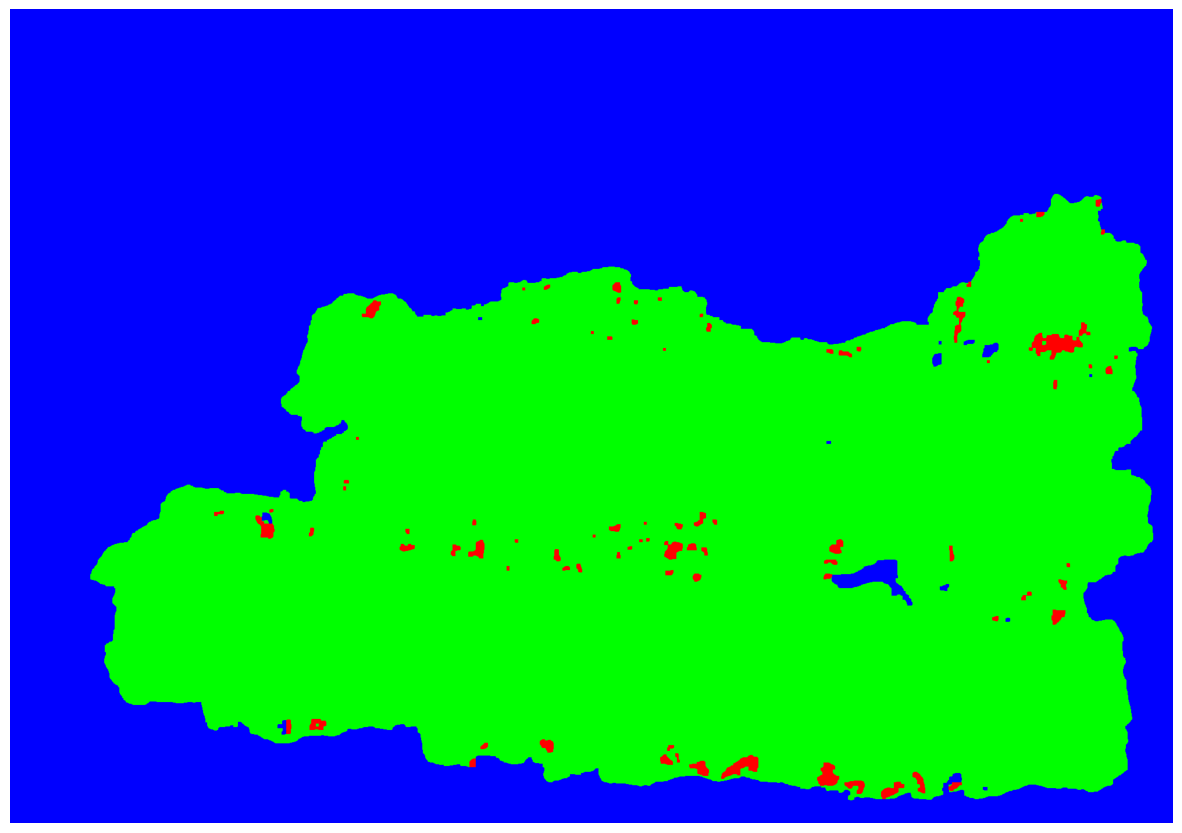

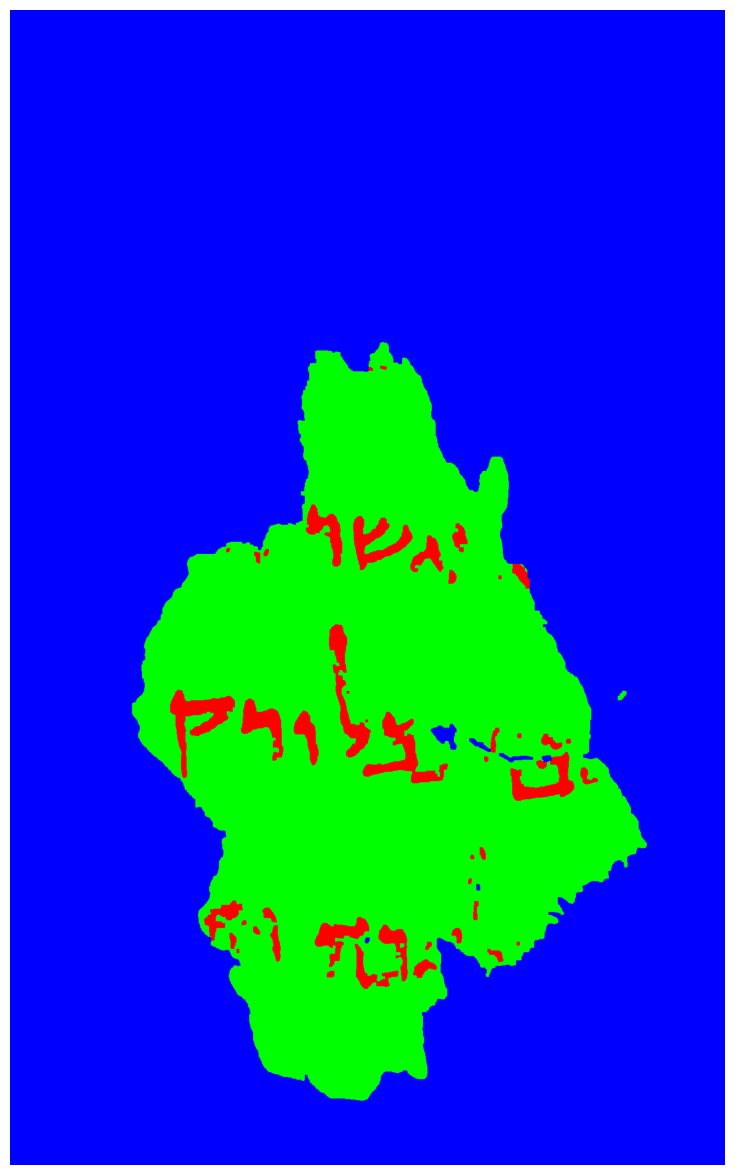

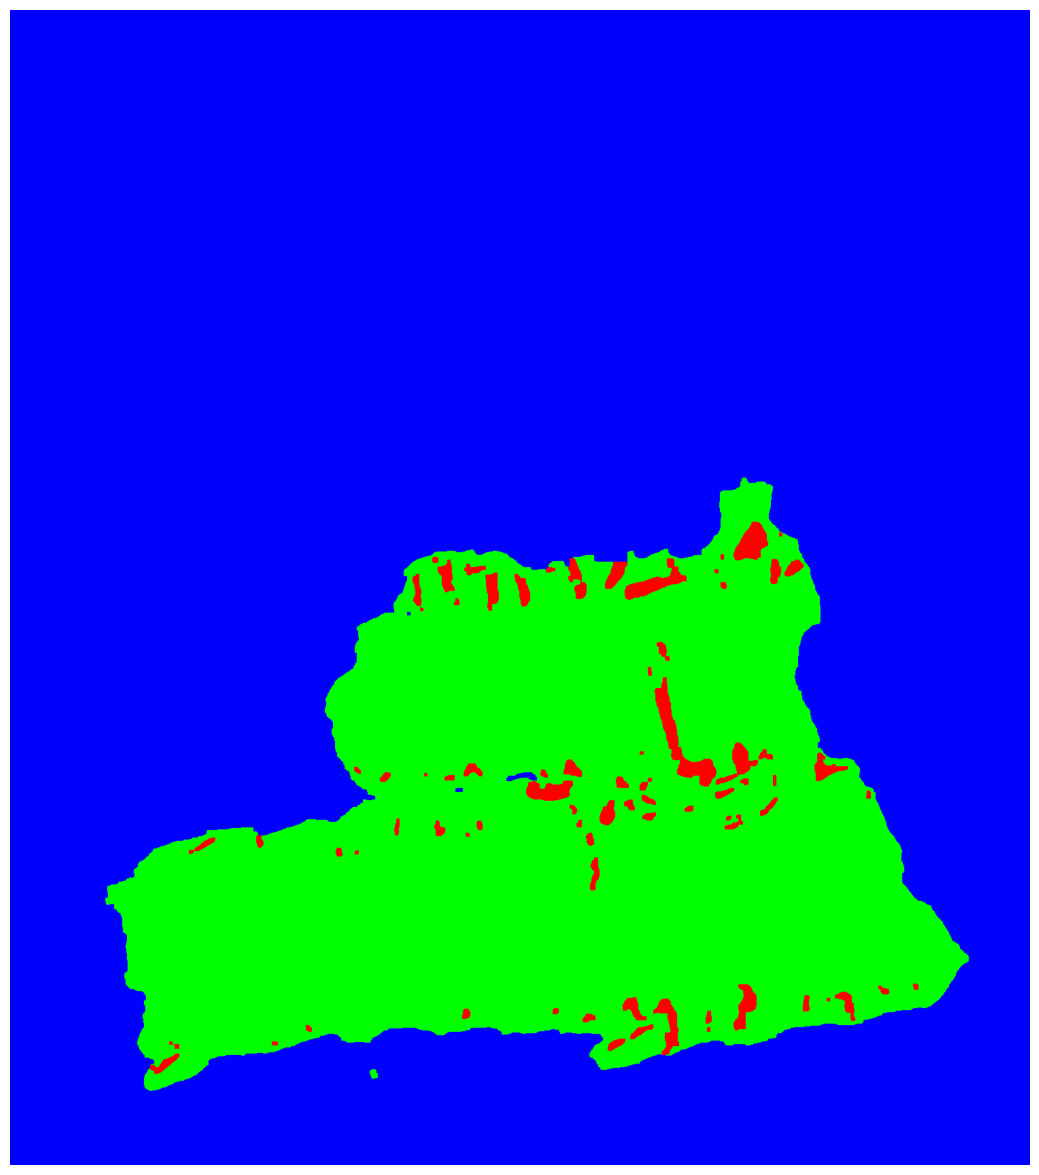

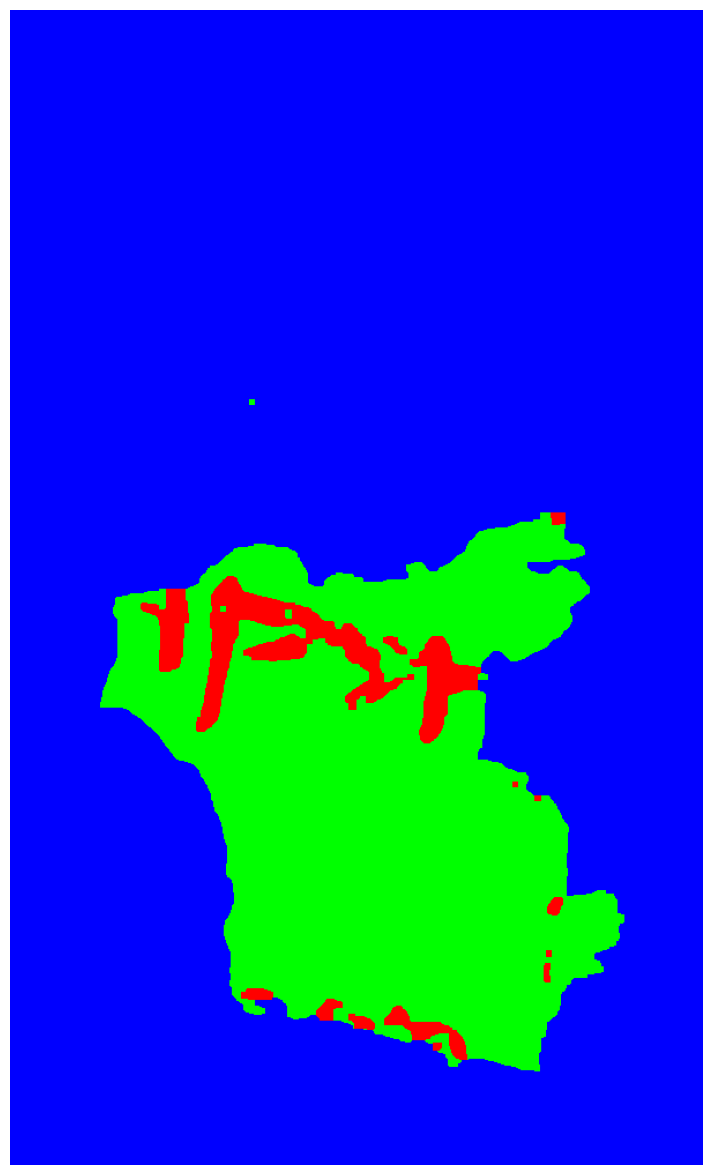

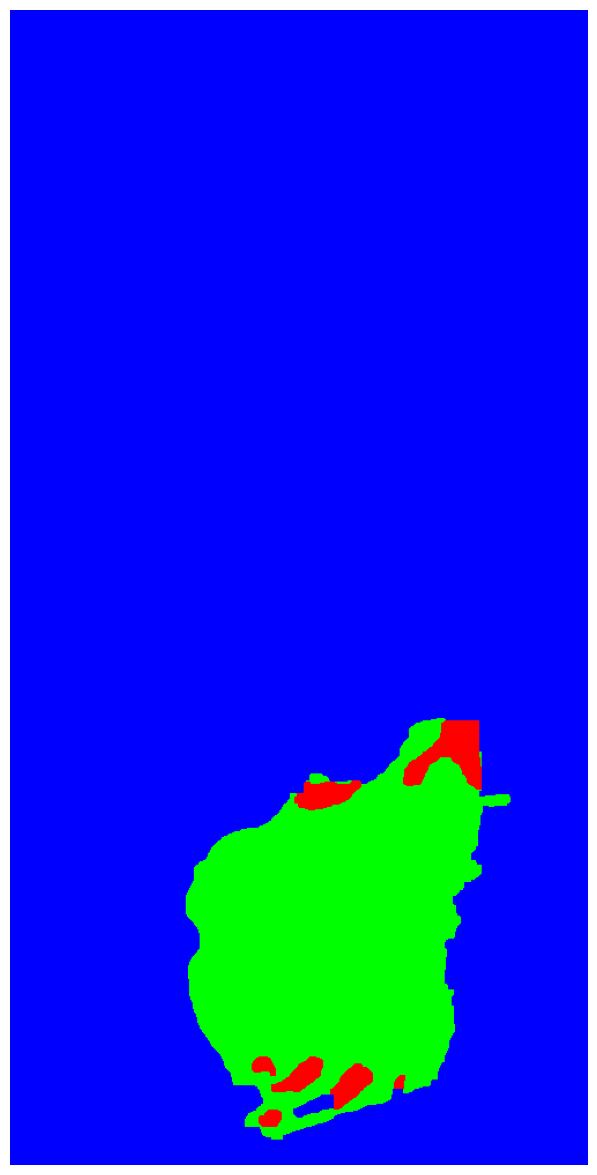

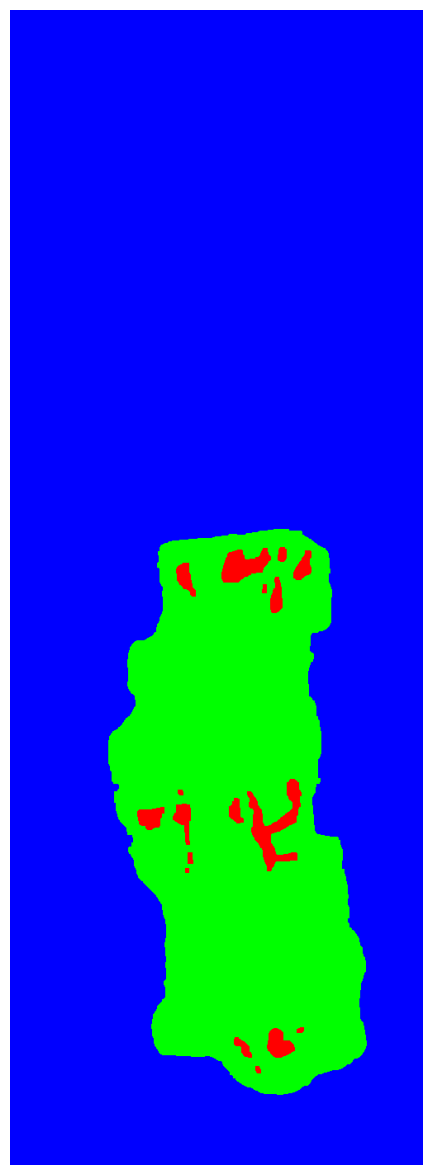

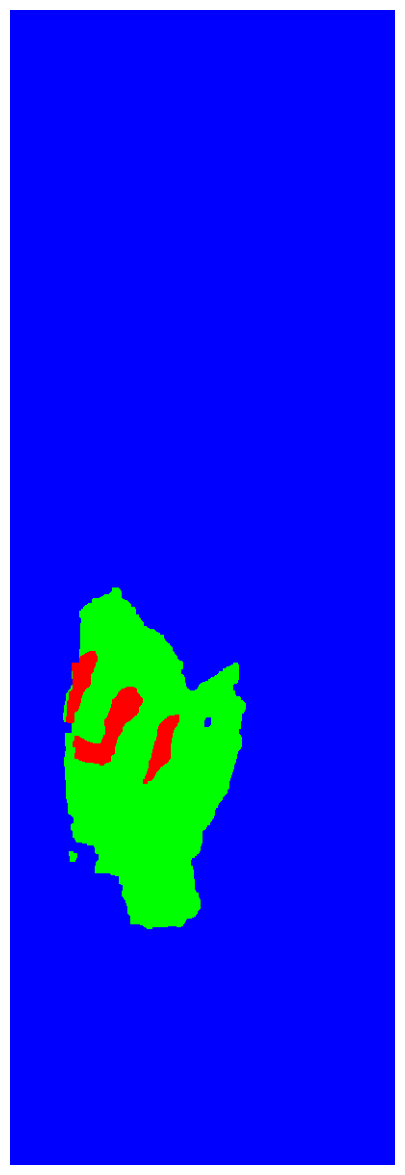

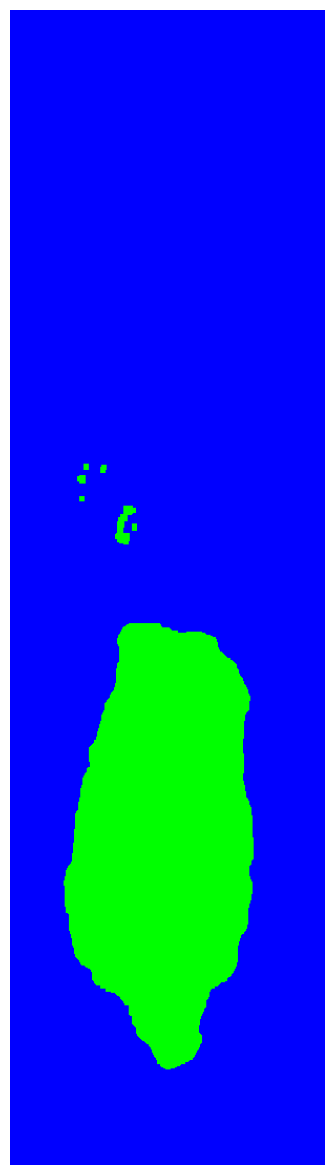

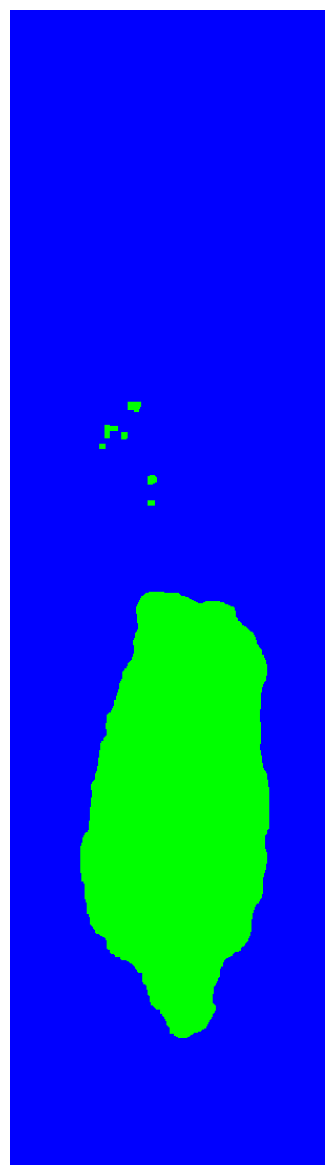

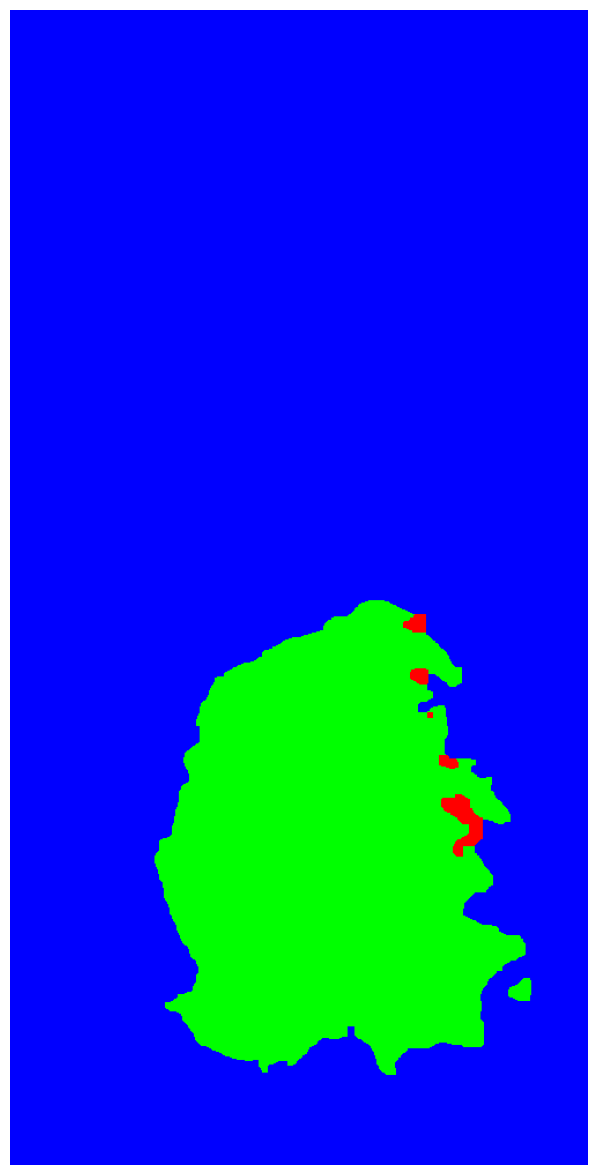

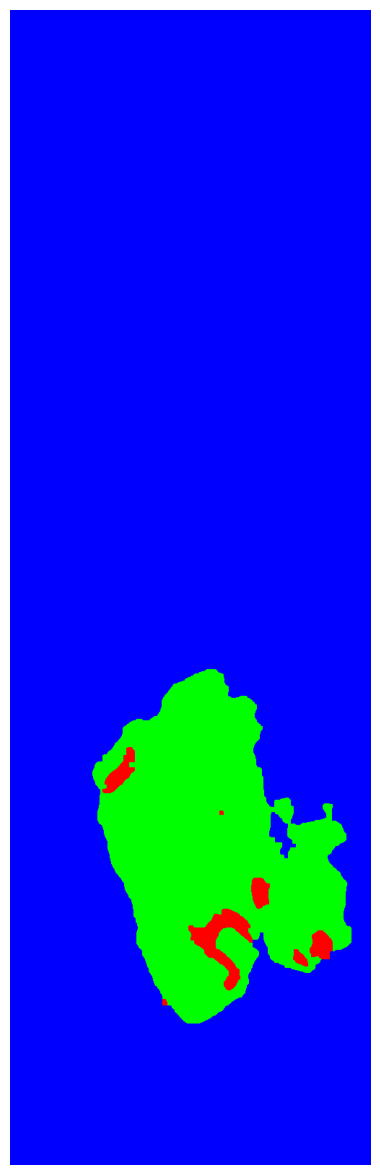

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import maxflow

# List of fragments to process
fragments = [
    '124_001', '124_002', '124_004', '124_005', '124_006', '124_007', '124_008', '124_009',
    '198_006', '198_007', '690_003', '690_004', '690_007', '690_008', '690_011', '690_014',
    '690_015', '690_016', '690_018', '690_019'
]

# Base paths
input_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/qumran_segmentation_dataset/multispectral_images/"
output_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/"

def create_mask(i1, i12, conditions):
    mask = np.ones_like(i1, dtype=bool)
    for cond in conditions:
        mask &= cond
    result = np.zeros_like(i1)
    result[mask] = 255
    return np.uint8(result)

for fragment in fragments:
    # Load images
    i1_path = os.path.join(input_base, fragment + "_001.tif")
    i12_path = os.path.join(input_base, fragment + "_012.tif")
    i1 = cv2.imread(i1_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
    i12 = cv2.imread(i12_path, cv2.IMREAD_UNCHANGED).astype(np.float64)

    # Define various masks
    par1 = create_mask(i1, i12, [i12 - i1 > 350, i1 > 300])
    par2 = create_mask(i1, i12, [i12 - i1 > 350, i1 <= 300, i1 > 80])
    par3 = create_mask(i1, i12, [i12 - i1 > 350, i1 <= 80])

    rice1 = create_mask(i1, i12, [i12 - i1 <= 350, i12 - i1 > 0, i1 > 200])
    rice2 = create_mask(i1, i12, [i12 - i1 <= 0, i1 > 300])
    rice3 = create_mask(i1, i12, [i12 - i1 <= 0, i1 <= 300, i1 > 80])

    ink1 = create_mask(i1, i12, [i12 - i1 <= 350, i12 - i1 > 0, i1 > 80, i1 <= 300])
    ink2 = create_mask(i1, i12, [i12 - i1 <= 350, i12 - i1 > 250, i1 > 80, i1 <= 300])

    back1 = create_mask(i1, i12, [i12 - i1 <= 75, i12 - i1 > 0, i1 > 80, i1 <= 110])
    hole1 = create_mask(i1, i12, [i12 - i1 <= 350, i12 - i1 > 0, i1 <= 80])
    hole2 = create_mask(i1, i12, [i12 - i1 <= 0, i1 <= 80])

    # Combine masks
    par = cv2.bitwise_or(par1, cv2.bitwise_or(par2, par3))
    rice = cv2.bitwise_or(rice1, cv2.bitwise_or(rice2, rice3))
    hole = cv2.bitwise_or(hole1, hole2)
    riceholeback = cv2.bitwise_or(cv2.bitwise_or(rice, hole), back1)

    # Graph-cut segmentation function
    def graph_cut_segmentation(imagetoseg, h, i):
        white_pixels_mask = imagetoseg > 0
        dist_transform_h = cv2.distanceTransform(255 - h, cv2.DIST_L2, 5)
        dist_transform_i = cv2.distanceTransform(255 - i, cv2.DIST_L2, 5)
        data_cost_h = np.where(white_pixels_mask, 1 / (1 + dist_transform_h), np.inf)
        data_cost_i = np.where(white_pixels_mask, 1 / (1 + dist_transform_i), np.inf)

        num_white_pixels = np.sum(white_pixels_mask)
        g = maxflow.Graph[float](num_white_pixels, num_white_pixels * 4)
        node_ids = g.add_nodes(num_white_pixels)

        white_pixel_indices = np.argwhere(white_pixels_mask)
        node_id_map = np.full(white_pixels_mask.shape, -1, dtype=int)
        node_id_map[white_pixels_mask] = node_ids

        for node_id, (y, x) in enumerate(white_pixel_indices):
            g.add_tedge(node_id, data_cost_h[y, x], data_cost_i[y, x])

        for y, x in white_pixel_indices:
            if y + 1 < white_pixels_mask.shape[0] and white_pixels_mask[y + 1, x]:
                g.add_edge(node_id_map[y, x], node_id_map[y + 1, x], 1, 1)
            if x + 1 < white_pixels_mask.shape[1] and white_pixels_mask[y, x + 1]:
                g.add_edge(node_id_map[y, x], node_id_map[y, x + 1], 1, 1)

        g.maxflow()
        result = np.zeros_like(white_pixels_mask, dtype=bool)
        for node_id, (y, x) in enumerate(white_pixel_indices):
            result[y, x] = g.get_segment(node_id)

        return result.astype(np.uint8) * 255

    # Apply graph-cut segmentation
    ink_contours = graph_cut_segmentation(ink2, riceholeback, par)
    invpar = cv2.bitwise_not(par)
    ink = graph_cut_segmentation(invpar, par, ink_contours)

    # Clean the masks with morphological operations
    def clean_mask(mask):
        kernel = np.ones((5, 5), np.uint8)
        clean_white = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        inverted_image = cv2.bitwise_not(clean_white)
        clean_black = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
        return cv2.bitwise_not(clean_black)

    clean_ink = clean_mask(ink)
    inkpar = cv2.bitwise_or(par, ink)
    inkpar = cv2.bitwise_or(inkpar, clean_ink)
    clean_inkpar = clean_mask(inkpar)
    background = cv2.bitwise_not(clean_inkpar)

    # Save masks
    cv2.imwrite(os.path.join(output_base, 'ink_masks', fragment + '.png'), clean_ink)
    cv2.imwrite(os.path.join(output_base, 'parchment_masks', fragment + '.png'), clean_inkpar)
    cv2.imwrite(os.path.join(output_base, 'background_masks', fragment + '.png'), background)

    # Create a color visualization
    redink_blueback_greenparchment = np.zeros((i1.shape[0], i1.shape[1], 3), dtype=np.uint8)
    redink_blueback_greenparchment[clean_inkpar == 255] = [0, 255, 0]
    redink_blueback_greenparchment[background == 255] = [255, 0, 0]
    redink_blueback_greenparchment[clean_ink == 255] = [0, 0, 255]

    # Display and save visualization
    plt.figure(figsize=(15, 15))
    plt.imshow(redink_blueback_greenparchment[:, :, ::-1])
    plt.axis('off')
    plt.show()

    cv2.imwrite(os.path.join(output_base, 'colored_ink_parchment_masks', fragment + '.png'), redink_blueback_greenparchment)
